## 机器学习工程师纳米学位毕业项目

作者 meelo

### Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

![](http://ufldl.stanford.edu/housenumbers/32x32eg.png)
Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 

### Download & load data

Download the training data and testing data from url below, and put it in the same directory as this notebook.  
Training data: http://ufldl.stanford.edu/housenumbers/train_32x32.mat  
Testing data: http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [19]:
%%bash
url=http://ufldl.stanford.edu/housenumbers/
training=train_32x32.mat
testing=test_32x32.mat
if [ ! -f $training ]; then
  wget $url$training
  echo "Successfully download training dataset"
fi
if [ ! -f $testing ]; then
  wget $url$testing
  echo "Successfully download testing dataset"
fi

In [1]:
# load file from .mat fi
from __future__ import print_function
from scipy import io

train_raw = io.loadmat('train_32x32.mat')
train_dataset_raw = train_raw['X']
train_labels_raw = train_raw['y']

print('Training dataset shape: ', train_dataset_raw.shape)
print('Training labels shape: ', train_labels_raw.shape)

test_raw = io.loadmat('test_32x32.mat')
test_dataset_raw = test_raw['X']
test_labels_raw = test_raw['y']

print('Testing dataset shape: ', test_dataset_raw.shape)
print('Testing labels shape: ', test_labels_raw.shape)

Training dataset shape:  (32, 32, 3, 73257)
Training labels shape:  (73257, 1)
Testing dataset shape:  (32, 32, 3, 26032)
Testing labels shape:  (26032, 1)


### 修改数据的格式

在原始数据集中，图片的格式是RGB。然而，图片的颜色对于数字的识别来说，通常没有价值。将彩色图片转换成灰度图能够将数据集的大小减小3倍。  
从上面数据集的形状可以看到，第1维和第2维表示图片的高与宽，第3维表示图片的色彩通道，第4维表示不同的图片。通常在机器学习中，用第1维表示不同的样本，将使用numpy.rollaxis函数修改维度的顺序。  

In [9]:
import numpy as np

train_dataset_color = np.rollaxis(train_dataset_raw, 3, 0) # Make the third dimension zeroth dimension
train_dataset_grey = train_dataset_color.mean(3) # In CNN ,we keep the third dimension as channel keepdims=True

print('Training dataset shape (grey scale): ', train_dataset_grey.shape)

test_dataset_color = np.rollaxis(test_dataset_raw, 3, 0) # Make the third dimension zeroth dimension
test_dataset_grey = test_dataset_color.mean(3) # In CNN ,we keep the third dimension as channel

print('Testing dataset shape (grey scale): ', test_dataset_grey.shape)

train_labels = train_labels_raw.flatten()
test_labels = test_labels_raw.flatten()

print('Training labels shape: ', train_labels.shape)
print('Testing labels shape: ', test_labels.shape)

Training dataset shape (grey scale):  (73257, 32, 32)
Testing dataset shape (grey scale):  (26032, 32, 32)
Training labels shape:  (73257,)
Testing labels shape:  (26032,)


### 图片减去均值
将图片的表示范围变换成(-0.5, 0.5)

In [10]:
pixel_depth = 255.0  # Number of levels per pixel.

train_dataset_grey = (train_dataset_grey - pixel_depth / 2 ) / pixel_depth
test_dataset_grey = (test_dataset_grey - pixel_depth / 2 ) / pixel_depth

In [11]:
print(train_dataset_grey[0])

[[-0.36797386 -0.4254902  -0.43333333 ..., -0.24771242 -0.21764706
  -0.20326797]
 [-0.36666667 -0.42026144 -0.43333333 ..., -0.33137255 -0.26862745
  -0.21111111]
 [-0.34444444 -0.41503268 -0.42679739 ..., -0.37320261 -0.34183007
  -0.24640523]
 ..., 
 [-0.18366013 -0.18627451 -0.20457516 ..., -0.11437908 -0.12091503
  -0.12614379]
 [-0.19411765 -0.19019608 -0.19934641 ..., -0.11176471 -0.1130719
  -0.1130719 ]
 [-0.18496732 -0.18235294 -0.19803922 ..., -0.10522876 -0.10784314
  -0.12352941]]


### 随机打乱原始数据

bug can't figure out why

In [5]:
"""
seed = 42
np.random.seed(seed)
permutation = np.random.permutation(train_dataset_grey.shape[0])
shuffled_dataset_grey = train_dataset_grey[permutation]
shuffled_labels = train_labels[permutaion]

print('Training dataset shape (grey scale): ', shuffled_dataset_grey.shape)
print('Training labels shape: ', shuffled_labels.shape)
"""

"\nseed = 42\nnp.random.seed(seed)\npermutation = np.random.permutation(train_dataset_grey.shape[0])\nshuffled_dataset_grey = train_dataset_grey[permutation]\nshuffled_labels = train_labels[permutaion]\n\nprint('Training dataset shape (grey scale): ', shuffled_dataset_grey.shape)\nprint('Training labels shape: ', shuffled_labels.shape)\n"

### 数据的可视化

在我们继续进行下一步操作之前，非常有必要查看数据的格式是否符合预期的要求。我们的数据是图片，可视化就可以简单地把图片画出来，并对比图片的标签是否正确。

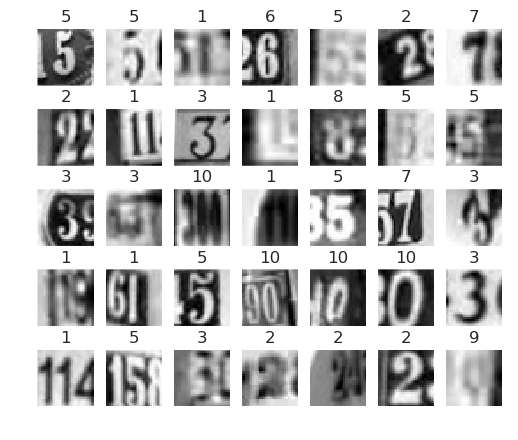

In [12]:
# Make sure image still look good
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
for ax in axes.flatten():
    random_idx = random.randint(0, test_dataset_grey.shape[0]-1)
    ax.axis('off')
    ax.imshow(train_dataset_grey[random_idx], cmap=plt.cm.gray, interpolation='none')
    ax.set_title(train_labels[random_idx])

### 查看数据的分布

可以看到在训练数据集中，数字1出现的频率是数字9出现频率的3倍。测试集数字的分布于训练集相同。

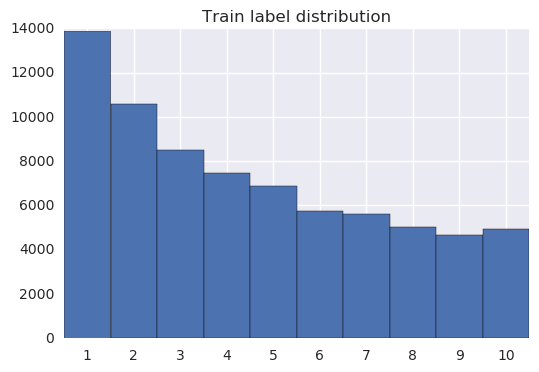

In [8]:
NUM_LABELS = 10

plt.xticks(np.arange(1, NUM_LABELS+1))
plt.hist(train_labels, bins=np.arange(1, NUM_LABELS+2)-0.5)
plt.title('Train label distribution')

### 构建交叉验证数据集(cross validation dataset)

原始数据中并不包含用于交叉验证验证的数据。
从训练数据中选择1%作为交叉验证数据集。交叉验证数据集不需要很大。因为我们通常使用随机梯度下降训练深度学习模型，每一次都只使用训练数据集中的一小部分。  
开始犯了一个错误，把交叉验证集设置得太大
 

In [13]:
valid_size = int(train_dataset_grey.shape[0] * 0.01)
valid_dataset = train_dataset_grey[:valid_size]
valid_labels = train_labels[:valid_size]

print('Valid dataset shape (grey scale): ', valid_dataset.shape)

train_dataset = train_dataset_grey[valid_size:]
train_labels = train_labels[valid_size:]

print('Training dataset shape (grey scale): ', train_dataset.shape)

Valid dataset shape (grey scale):  (732, 32, 32)
Training dataset shape (grey scale):  (72525, 32, 32)


### 保存经过预处理的数据

pickle模块实现了一种算法，将任意一个Python对象转化成一系列字节（byets）。此过程也调用了serializing对象。代表对象的字节流之后可以被传输或存储，再重构后创建一个拥有相同特征（the same characteristics）的新的对象。  
cPickle使用C而不是Python，实现了相同的算法。这比Python实现要快好几倍，但是它不允许用户从Pickle派生子类。如果子类对你的使用来说无关紧要，那么cPickle是个更好的选择。

保存4维数据还是3维数据
775MB→658MB

In [14]:
# save processed data in a pickle file
from six.moves import cPickle as pickle

dataset = {
    'train_dataset': train_dataset,
    'train_labels': train_labels, 
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset_grey,
    'test_labels': test_labels
}

pickle_file = 'svhn_single.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)